# Decision Tree

Los **arboles de decision** son modelos predictivos formados por reglas binarias, con lo que se consigue
repartir las observaciones en función de sus atributos y predecir así el valor de la variable.
La ventaja de usar este algoritmo es que son facilmente interpretables y permite manejar datos enteros cómo
categoricos y a su vez poder darle una representación gráfica (no es el caso de random forest, boosting...)

### Cargamos librerias

In [9]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pickle

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings

In [10]:
def evaluate_model(y_test, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_test, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(y_test, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(y_test, ypred)))

### Descargamos el entrenamiento y el test

In [11]:
X_train_lasso = pd.read_parquet("X_train_lasso.parquet")
y_train = pd.read_parquet("y_train.parquet")
X_test_lasso = pd.read_parquet("X_test_lasso.parquet")
y_test = pd.read_parquet("y_test.parquet")

In [11]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 3,
            criterion         = 'gini',
            random_state      = 0
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_lasso, y_train)

C:\Users\pablo\Anaconda3\envs\core_models\lib\site-packages\sklearn\tree\_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


DecisionTreeClassifier(max_depth=3, random_state=0)

In [12]:
# Cargamos el modelo para no tener que volver a entrenarlo
with open('Decision_Tree.pkl', 'rb') as f: 
    modelo = pickle.load(f)

Profundidad del árbol: 3
Número de nodos terminales: 8


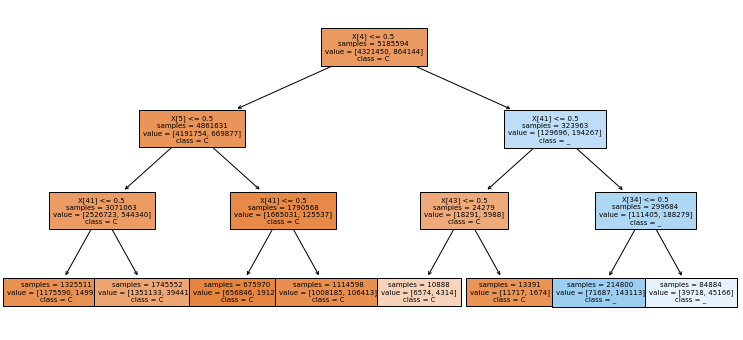

In [13]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            class_names   = 'C_SEV',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

Calculamos las predicciones del test

In [14]:
ypred = modelo.predict(X_test_lasso)
ypred_proba = modelo.predict_proba(X_test_lasso)

In [16]:
print("Classification report:")
print(classification_report(y_test, ypred))

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91   1440322
           1       0.63      0.22      0.33    288210

    accuracy                           0.85   1728532
   macro avg       0.75      0.60      0.62   1728532
weighted avg       0.82      0.85      0.82   1728532



In [18]:
recall_score(y_test, ypred)

0.2196141702231012

In [19]:
precision_score(y_test, ypred)

0.6302838991067783

### Matriz de confusion

Cada columna de la matriz representa el número de predicciones de cada clase, y cada fila representa el numero real. Nos permite ver qué tipos de aciertos y errores eestá teniendo nuestro modelo a la hora de pasar por el aprendizaje o entrenamiento con los datos.

Hay 4 resultados posibles: Verdadero positivo, Verdadero negativo, Falso positivo, Falso negativo.

[[Verdadero positivo, Falso positivo],

 [Falso negativo, Verdadero negativo]]

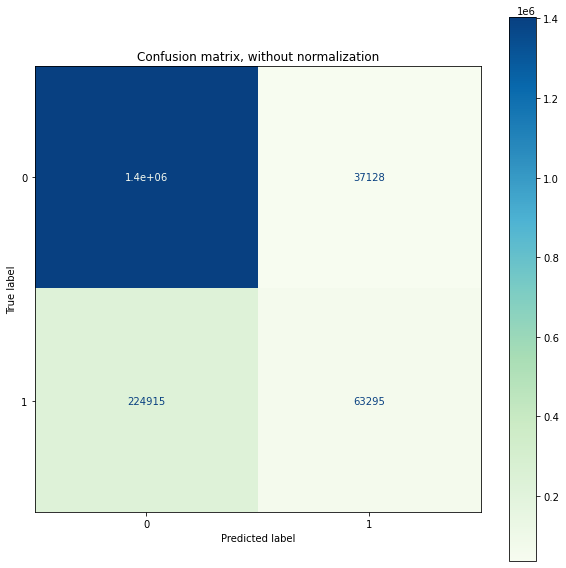

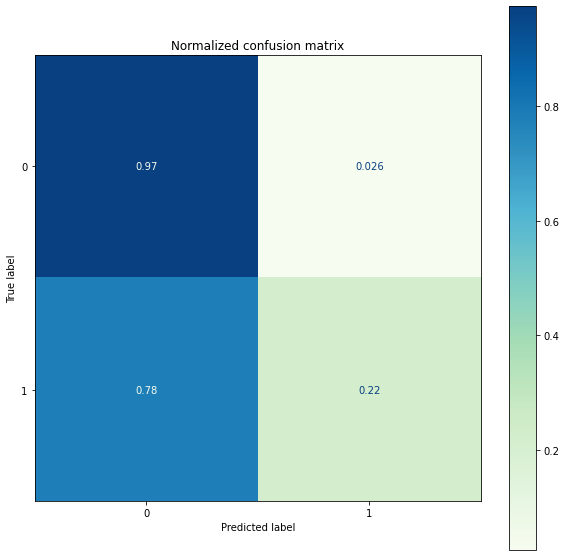

In [20]:
# Matrices de confusion
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, ypred,
                                                       cmap=plt.cm.GnBu,
                                                       normalize=normalize,
                                                       ax=ax)
    ax.set_title(title)

### Curvas ROC-AUC

La curva ROC es una grafica que enfrenta ele ratio de falsos positivos (eje x) con el ratio de falsos negativos (eje y). Compara la "falsa alarma" con la tasa de éxito. El area debajo de la curva (AUC) es utilizado como resumen de la calidad del modelo, cuando mayor sea este area, según se desplaza la curva hacia la esquina superior izquierda del gráfico, la calidad del modelo aumenta.

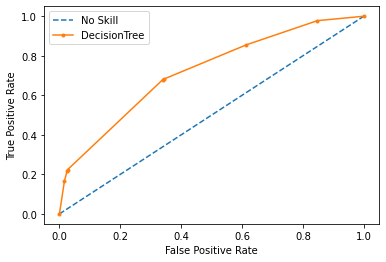

In [22]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='DecisionTree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [23]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [24]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.225957, G-Mean=0.670


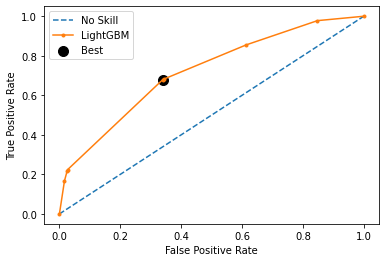

In [25]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Curvas Precision-Recall

La **precisión** se calcula como el número de verdaderos positivos entre la suma de verdaderos positivos y de falsos postivos. Muestra cómo de bueno es el modelo a la hora de predecir las salidad de la clase positiva.

**Sensibilidad** se calcula como el número de verdaderos positivos divididos entre la suma de verdaderos postivos y de falsos positivos.

La curva de precision-sensibilidad enfrenta la precision (eje y) con la sensibilidad (eje x). En este caso cuanto mas se acerque la linea a la parte derecha superior del grafico el modelo será mejor.

In [26]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

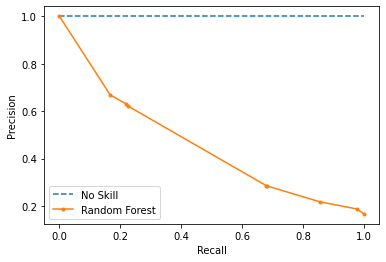

In [27]:
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.225957, F-Score=0.402


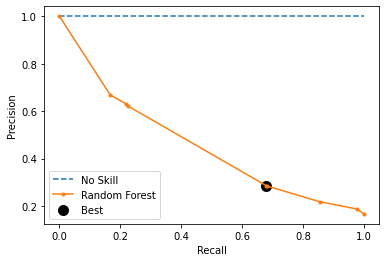

In [28]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

El valor **F-Score**, calcula la media armonica de la precision y la sensibilidad.

En terminos de evaluación de modelo, el valor F resume la habilidad del modelo para un valor especifico del umbral. Como comparativ, el AUC contempla la habilidad del modelo a lo largo de diversos umbrales. Esto convierte a la curva de precision-sensibilidad en la manera mas óptima de medir el rendimiento de modelos de clasificación.

In [29]:
# evaluate the model
score = f1_score(y_test, ypred)
print('F-Score: %.5f' % score)

F-Score: 0.32573


In [31]:
evaluate_model(y_test, ypred, ypred_proba)

ROC-AUC score of the model: 0.7200555361003379
Accuracy of the model: 0.8484014180819331

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.97      0.91   1440322
           1       0.63      0.22      0.33    288210

    accuracy                           0.85   1728532
   macro avg       0.75      0.60      0.62   1728532
weighted avg       0.82      0.85      0.82   1728532




# Guardamos los resultados de los modelos

In [44]:
with open('Decision_Tree.pkl', 'wb') as f:
    pickle.dump(modelo, f)